In [1]:
from tabulate import tabulate
from sklearn import preprocessing

In [2]:
import re
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from progressbar import Percentage, ProgressBar,Bar,ETA

In [3]:
from string import punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [4]:
import pickle
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

In [5]:
def getFeatures(data):
    pids = list(data["PID"])
    ans = []
    verbs_dataset = []
    r = data['PID'].max()
    l = data['PID'].min()
    bar = ProgressBar(widgets=[Bar('=', '[', ']'), ' ', Percentage(), ' ', ETA()], maxval=r).start()
    for pid in range(l, r+1):
        if pid in pids:
            pdata = data.loc[data['PID']==pid]
            sr = int(pdata['SID'].max())
            sl = int(pdata['SID'].min())
            for sid in range(sl, sr+1):
                sdata = pdata.loc[pdata['SID']==sid]
                mv_idx = list(sdata.query('POS == "V_VM"')['TID'])
                c = sdata['TID'].max()
                lemma = list(sdata['Root'])
                pos = list(sdata['POS'])
                dep = list(sdata['UD'])
                for v in mv_idx:
                    if v > 2 and c >= v+3:
                        bag = [pos[v-3], pos[v-2], pos[v-1], lemma[v], pos[v+1],pos[v+2], pos[v+3], dep[v-3], dep[v-2], dep[v-1], lemma[v], dep[v+1],dep[v+2], dep[v+3]]
                    elif v == 2 and c >= v+3:
                        bag = ['NULL', pos[v-2], pos[v-1], lemma[v], pos[v+1],pos[v+2], pos[v+3], 'NULL', dep[v-2], dep[v-1], lemma[v], dep[v+1],dep[v+2], dep[v+3]]
                    elif v == 1 and c >= v+3:
                        bag = ['NULL', 'NULL', pos[v-1], lemma[v], pos[v+1],pos[v+2], pos[v+3], 'NULL', 'NULL', dep[v-1], lemma[v], dep[v+1],dep[v+2], dep[v+3]]
                    elif v == 0 and c >= v+3:
                        bag = ['NULL', 'NULL', 'NULL', lemma[v], pos[v+1],pos[v+2], pos[v+3], 'NULL', 'NULL', 'NULL', lemma[v], dep[v+1],dep[v+2], dep[v+3]]
                    elif v > 2 and c == v+2:
                        bag = [pos[v-3], pos[v-2], pos[v-1], lemma[v], pos[v+1],pos[v+2], 'NULL', dep[v-3], dep[v-2], dep[v-1], lemma[v], dep[v+1],dep[v+2], 'NULL']
                    elif v == 2 and c == v+2:
                        bag = ['NULL', pos[v-2], pos[v-1], lemma[v], pos[v+1],pos[v+2], 'NULL', 'NULL', dep[v-2], dep[v-1], lemma[v], dep[v+1],dep[v+2], 'NULL']
                    elif v == 1 and c == v+2:
                        bag = ['NULL', 'NULL', pos[v-1], lemma[v], pos[v+1],pos[v+2], 'NULL', 'NULL', 'NULL', dep[v-1], lemma[v], dep[v+1],dep[v+2], 'NULL']
                    elif v == 0 and c == v+2:
                        bag = ['NULL', 'NULL', 'NULL', lemma[v], pos[v+1],pos[v+2], 'NULL', 'NULL', 'NULL', 'NULL', lemma[v], dep[v+1],dep[v+2], 'NULL']
                    elif v > 2 and c == v+1:
                        bag = [pos[v-3], pos[v-2], pos[v-1], lemma[v], pos[v+1],'NULL', 'NULL', dep[v-3], dep[v-2], dep[v-1], lemma[v], dep[v+1],'NULL', 'NULL']
                    elif v == 2 and c == v+1:
                        bag = ['NULL', pos[v-2], pos[v-1], lemma[v], pos[v+1],'NULL', 'NULL', 'NULL', dep[v-2], dep[v-1], lemma[v], dep[v+1],'NULL', 'NULL']
                    elif v == 1 and c == v+1:
                        bag = ['NULL', 'NULL', pos[v-1], lemma[v], pos[v+1],'NULL', 'NULL', 'NULL', 'NULL', dep[v-1], lemma[v], dep[v+1],'NULL', 'NULL']
                    elif v == 0 and c == v+1:
                        bag = ['NULL', 'NULL', 'NULL', lemma[v], pos[v+1],'NULL', 'NULL', 'NULL', 'NULL', 'NULL', lemma[v], dep[v+1],'NULL', 'NULL']
                    elif v > 2 and c == v:
                        bag = [pos[v-3], pos[v-2], pos[v-1], lemma[v], 'NULL','NULL', 'NULL', dep[v-3], dep[v-2], dep[v-1], lemma[v], 'NULL','NULL', 'NULL']
                    elif v == 2 and c == v:
                        bag = ['NULL', pos[v-2], pos[v-1], lemma[v],'NULL','NULL', 'NULL', 'NULL', dep[v-2], dep[v-1], lemma[v],'NULL','NULL', 'NULL']
                    elif v == 1 and c == v:
                        bag = ['NULL', 'NULL',pos[v-1], lemma[v], 'NULL','NULL', 'NULL', 'NULL', 'NULL',dep[v-1], lemma[v], 'NULL','NULL', 'NULL']
                    elif v == 0 and c == v:
                        bag = ['NULL', 'NULL', 'NULL', lemma[v], 'NULL','NULL', 'NULL', 'NULL', 'NULL', 'NULL', lemma[v], 'NULL','NULL', 'NULL']

                    feature = [bag]
                    ans.append(feature)
                    verbs_dataset.append(lemma[v])
        bar.update(pid)
    features = pd.DataFrame(ans,columns=['features'])
    print(features)
    return features, verbs_dataset

In [6]:
def kFoldCrossValidation(n, X, y, model):
    skf = StratifiedKFold(n_splits=n, shuffle=True)
    for train_index, test_index in skf.split(X, y):
        print(train_index, test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]      
        X_train = pd.DataFrame(X_train, columns =['features'])
        print(X_train)
        y_train = pd.DataFrame(y_train, columns =['labels'])
        print(y_train)
        if(model == "svm"):
            predicted_test_labels = svm(X_train, y_train, list(X_test))
        elif(model == "logreg"):
            predicted_test_labels = logReg(X_train, y_train, list(X_test))
        elif(model == "rfc"):
            predicted_test_labels = randomForest(X_train, y_train, list(X_test))
        getResult(list(y_test), predicted_test_labels)
#     return predicted_test_labels

In [7]:
def svm(training_data, training_labels, test_samples):
#     with open('./hindi-verb-cat-svm', 'rb') as file:  
#         clf = pickle.load(file)  
    clf = SVC(kernel="linear")
    clf.fit(training_data, training_labels)
    pickle.dump(clf, open("./hindi-verb-cat-svm-bow-six", 'wb'))
    return clf.predict(test_samples)

In [8]:
def randomForest(training_data, training_labels, test_samples):
#     with open('./hindi-verb-cat-rfc', 'rb') as file:  
#         rfc = pickle.load(file)
    rfc = RandomForestClassifier(random_state=1, n_estimators=400)
    rfc.fit(training_data, training_labels)
    pickle.dump(rfc, open("./hindi-verb-cat-rfc-bow-six", 'wb'))
    return rfc.predict(test_samples)

In [9]:
def logReg(training_data, training_labels, test_samples):
#     with open('./hindi-verb-cat-logreg', 'rb') as file:  
#         logreg = pickle.load(file)
    logreg = LogisticRegression(random_state=42).fit(training_data, training_labels)
    pickle.dump(logreg, open("./hindi-verb-cat-logreg-bow-six", 'wb'))
    return logreg.predict(test_samples)

In [10]:
def vectorise_using_tfidf(training_samples, test_samples):
    punctuation = "!#$%&'()*+,-./:;<=>?@[\]^_`{|}~\"।"
    sample_list=[]
    training_samples = list(training_samples['features'])
    for sample in training_samples:
        sample_list.append(' '.join(sample))
    vectorizer = TfidfVectorizer(token_pattern='(?u)\\s?\w+\\s?|\\s?[' + punctuation + ']\\s?', ngram_range=(1, 1))
    train_matrix = vectorizer.fit_transform(sample_list)

    sample_list=[]
    test_samples = list(test_samples['features'])
    for sample in test_samples:
        sample_list.append(' '.join(sample))
    test_matrix = vectorizer.transform(sample_list)
    return train_matrix, test_matrix

In [152]:
def getPredictions(training_samples, test_samples, training_labels, model):
    train_matrix, test_matrix = vectorise_using_tfidf(training_samples, test_samples)
    if model == "svm":
        print('Predicting using SVM...')
        predicted = svm(train_matrix, training_labels, test_matrix)
    elif model == "rfc":
        print('Predicting using Random Forest...')
        predicted = randomForest(train_matrix, training_labels, test_matrix)
    else:
        print('Predicting using Logistic Regression...')
        predicted = logReg(train_matrix, training_labels, test_matrix)
    return predicted

In [164]:
def getResult(y_true, predicted):
    print('Results...')
    y_pred = list(predicted)
    labels = ['+','-','0', 't+', 't-','na']
    recall = recall_score(y_true, y_pred, labels=labels, average=None)
    precision = precision_score(y_true, y_pred, labels=labels, average=None)
    f1 = f1_score(y_true, y_pred, labels=labels, average=None)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig = plt.subplots(figsize=[6,6])
    fig = sns.heatmap(cm/np.sum(cm), fmt='.2%',annot=True, cmap='Blues', cbar=False)
    plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], labels)
    plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], labels)
    plt.xlabel('Predicted Category')
    plt.ylabel('Actual Category')
    
    recall = np.reshape(recall, (-1, 1))
    precision = np.reshape(precision, (-1, 1))
    f1 = np.reshape(f1, (-1, 1))
    labels = np.reshape(np.array(labels), (-1, 1))
    header = [' ','Recall', 'Precision', 'F1-score']
    header = np.array(header)


    res = np.hstack((labels,recall,precision,f1))
    result = np.vstack((header, res))
    h = result[0]
    result = np.delete(result, (0), axis=0)

    print(tabulate(result, headers=h, tablefmt="fancy_grid"))
    print("meanf1:", np.mean(f1))
#     print("meanPrecision:", np.mean(precision))
#     print("meanRecall:", np.mean(recall))

In [154]:
def getDataAndLabels(data_set, all_data):
    set_pids = list(data_set['PID'])
    data_set = all_data[all_data['PID'].isin(set_pids)]
    data = data_set[['PID','SID','TID','Token','Root','POS','AnnCorra','UD']].copy()
    labels = data_set.loc[data_set['POS'] == 'V_VM'][['VerbCategory']].copy()
    labels['VerbCategory'] = labels['VerbCategory'].fillna('na')
    labels= list(labels['VerbCategory'])
#     labels = list(map(lambda x: x.replace('t+', 't'), labels))
#     labels = list(map(lambda x: x.replace('t-', 't'), labels))
    return data, labels

# Fold 3

In [167]:
all_data = pd.read_csv('data/all-verb-cat-data.csv', delimiter='\t')
train_verbs_set = pd.read_csv('data/train-test-sets-hawp-3/train3.csv', delimiter='\t')
test_verbs_set = pd.read_csv('data/train-test-sets-hawp-3/test3.csv', delimiter='\t')

In [168]:
train_X, train_y = getDataAndLabels(train_verbs_set, all_data)
test_X, test_y = getDataAndLabels(test_verbs_set, all_data)

In [169]:
train_features, train_verbs = getFeatures(train_X)

                                               features
0     [N_NN, DM_DMD, N_NN, खरीद, RD_PUNC, NULL, NULL...
1     [QT_QTF, PR_PRQ, N_NN, खरीद, RD_PUNC, NULL, NU...
2     [N_NN, QT_QTC, N_NN, है, RD_PUNC, NULL, NULL, ...
3     [N_NST, QT_QTC, N_NN, है, CC_CCS, V_VM, RD_PUN...
4     [N_NN, V_VM, CC_CCS, बता, RD_PUNC, PR_PRP, N_N...
...                                                 ...
5200  [N_NN, QT_QTF, N_NN, है, RD_PUNC, NULL, NULL, ...
5201  [N_NN, PSP, N_NNP, निकाल, RD_PUNC, NULL, NULL,...
5202  [PSP, PR_PRP, N_NNP, है, RD_PUNC, NULL, NULL, ...
5203  [NULL, NULL, N_NN, निकाल, PSP, N_NST, N_NN, NU...
5204  [PSP, PR_PRQ, N_NN, था, RD_PUNC, NULL, NULL, c...

[5205 rows x 1 columns]


In [170]:
test_features, test_verbs = getFeatures(test_X)

                                               features
0     [QT_QTC, N_NN, PSP, भर, DM_DMD, N_NN, N_NN, nu...
1     [N_NN, PSP, N_NN, का, RD_PUNC, NULL, NULL, nmo...
2     [PSP, QT_QTC, N_NN, था, CC_CCD, JJ, N_NN, case...
3     [CC_CCD, JJ, N_NN, था, RD_PUNC, NULL, NULL, cc...
4     [PSP, PR_PRQ, N_NN, था, RD_PUNC, NULL, NULL, c...
...                                                 ...
1297  [NULL, NULL, PR_PRP, निपट, PSP, PSP, N_NN, NUL...
1298  [N_NN, PSP, N_NN, छोड़, RD_PUNC, NULL, NULL, n...
1299  [N_NN, PSP, N_NN, था, CC_CCD, QT_QTC, N_NN, nm...
1300  [PSP, N_NN, RP_NEG, था, RD_PUNC, NULL, NULL, c...
1301  [PSP, RP_INTF, QT_QTF, है, RD_PUNC, NULL, NULL...

[1302 rows x 1 columns]


In [171]:
# for feature, label in zip(test_features['features'], test_y):
#     print(feature, label)

In [172]:
print(len(train_features), len(train_y), len(test_features), len(test_y))

5205 5205 1302 1302


# SVM 

In [173]:
svm_predicted = getPredictions(train_features, test_features, train_y, "svm")

Predicting using SVM...


Results...
╒═════╤══════════╤═════════════╤════════════╕
│     │   Recall │   Precision │   F1-score │
╞═════╪══════════╪═════════════╪════════════╡
│ +   │ 0.971888 │    0.966068 │   0.968969 │
├─────┼──────────┼─────────────┼────────────┤
│ -   │ 0.95122  │    0.879699 │   0.914062 │
├─────┼──────────┼─────────────┼────────────┤
│ 0   │ 0.998008 │    1        │   0.999003 │
├─────┼──────────┼─────────────┼────────────┤
│ t+  │ 1        │    1        │   1        │
├─────┼──────────┼─────────────┼────────────┤
│ t-  │ 1        │    1        │   1        │
├─────┼──────────┼─────────────┼────────────┤
│ na  │ 0.294118 │    1        │   0.454545 │
╘═════╧══════════╧═════════════╧════════════╛
meanf1: 0.8894299857568903


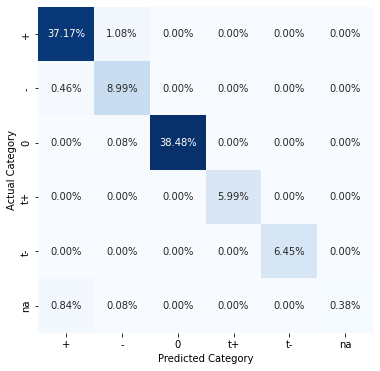

In [174]:
getResult(test_y, svm_predicted)

In [175]:
# K-FOLD: SVM

In [176]:
# X = pd.concat([train_features, test_features]).to_numpy()
# y = train_y + test_y
# kFoldCrossValidation(5, X, np.asarray(y), "svm")

# Random Forest Classifier

In [177]:
rfc_predicted = getPredictions(train_features, test_features, train_y, "rfc")

Predicting using Random Forest...


Results...
╒═════╤══════════╤═════════════╤════════════╕
│     │   Recall │   Precision │   F1-score │
╞═════╪══════════╪═════════════╪════════════╡
│ +   │ 0.993976 │    0.923507 │   0.957447 │
├─────┼──────────┼─────────────┼────────────┤
│ -   │ 0.837398 │    0.962617 │   0.895652 │
├─────┼──────────┼─────────────┼────────────┤
│ 0   │ 0.998008 │    0.994048 │   0.996024 │
├─────┼──────────┼─────────────┼────────────┤
│ t+  │ 0.923077 │    1        │   0.96     │
├─────┼──────────┼─────────────┼────────────┤
│ t-  │ 0.940476 │    0.9875   │   0.963415 │
├─────┼──────────┼─────────────┼────────────┤
│ na  │ 0.176471 │    1        │   0.3      │
╘═════╧══════════╧═════════════╧════════════╛
meanf1: 0.845422912238145


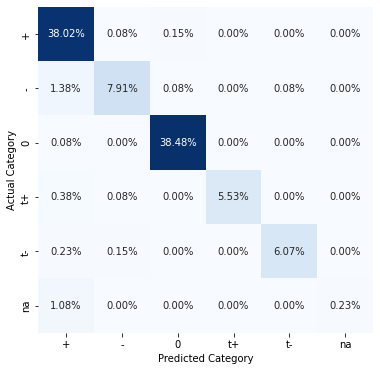

In [178]:
getResult(test_y, rfc_predicted)

# Logistic Regression

In [179]:
lg_predicted = getPredictions(train_features, test_features, train_y, "lg")

Predicting using Logistic Regression...


Results...
╒═════╤═══════════╤═════════════╤════════════╕
│     │    Recall │   Precision │   F1-score │
╞═════╪═══════════╪═════════════╪════════════╡
│ +   │ 0.975904  │    0.929254 │   0.952008 │
├─────┼───────────┼─────────────┼────────────┤
│ -   │ 0.861789  │    0.868852 │   0.865306 │
├─────┼───────────┼─────────────┼────────────┤
│ 0   │ 0.998008  │    0.996024 │   0.997015 │
├─────┼───────────┼─────────────┼────────────┤
│ t+  │ 0.935897  │    1        │   0.966887 │
├─────┼───────────┼─────────────┼────────────┤
│ t-  │ 0.952381  │    1        │   0.97561  │
├─────┼───────────┼─────────────┼────────────┤
│ na  │ 0.0588235 │    1        │   0.111111 │
╘═════╧═══════════╧═════════════╧════════════╛
meanf1: 0.8113228612841276


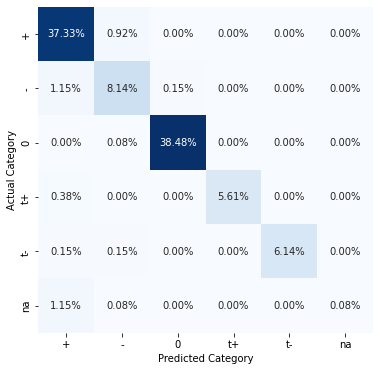

In [180]:
getResult(test_y, lg_predicted)

In [181]:
# test_features['label'] = test_y

In [182]:
# test_features

In [183]:
# test_features.to_csv('./test_samples-fold3.csv', sep="\t", index=False)

# fOld 0

In [184]:
all_data = pd.read_csv('data/all-verb-cat-data.csv', delimiter='\t')
train_verbs_set = pd.read_csv('data/train-test-sets-hawp-3/train0.csv', delimiter='\t')
test_verbs_set = pd.read_csv('data/train-test-sets-hawp-3/test0.csv', delimiter='\t')

In [185]:
train_X, train_y = getDataAndLabels(train_verbs_set, all_data)
test_X, test_y = getDataAndLabels(test_verbs_set, all_data)

In [186]:
train_features, train_verbs = getFeatures(train_X)

                                               features
0     [PSP, QT_QTC, N_NN, बैठ, V_VAUX, RD_PUNC, NULL...
1     [QT_QTC, N_NN, N_NNP, जा, RD_PUNC, NULL, NULL,...
2     [NULL, NULL, NULL, बता, RD_PUNC, PR_PRP, N_NN,...
3     [PSP, PR_PRQ, N_NN, रह, RD_PUNC, NULL, NULL, c...
4     [N_NST, QT_QTC, N_NN, था, CC_CCD, N_NNP, PSP, ...
...                                                 ...
5172  [N_NN, QT_QTF, N_NN, है, RD_PUNC, NULL, NULL, ...
5173  [N_NN, PSP, N_NNP, निकाल, RD_PUNC, NULL, NULL,...
5174  [PSP, PR_PRP, N_NNP, है, RD_PUNC, NULL, NULL, ...
5175  [NULL, NULL, N_NN, निकाल, PSP, N_NST, N_NN, NU...
5176  [PSP, PR_PRQ, N_NN, था, RD_PUNC, NULL, NULL, c...

[5177 rows x 1 columns]


In [187]:
test_features, test_verbs = getFeatures(test_X)

                                               features
0     [N_NN, DM_DMD, N_NN, खरीद, RD_PUNC, NULL, NULL...
1     [QT_QTF, PR_PRQ, N_NN, खरीद, RD_PUNC, NULL, NU...
2     [N_NN, QT_QTC, N_NN, है, RD_PUNC, NULL, NULL, ...
3     [N_NST, QT_QTC, N_NN, है, CC_CCS, V_VM, RD_PUN...
4     [N_NN, V_VM, CC_CCS, बता, RD_PUNC, PR_PRP, N_N...
...                                                 ...
1325  [QT_QTC, PSP, N_NN, कर, CC_CCD, QT_QTO, N_NN, ...
1326  [QT_QTC, N_NN, JJ, मिल, RD_PUNC, NULL, NULL, n...
1327  [PSP, PR_PRQ, N_NN, मिल, RD_PUNC, NULL, NULL, ...
1328  [QT_QTC, N_NN, N_NN, बेच, CC_CCS, PR_PRP, QT_Q...
1329  [QT_QTF, PR_PRQ, N_NN, बेच, RD_PUNC, NULL, NUL...

[1330 rows x 1 columns]


In [188]:
print(len(train_features), len(train_y), len(test_features), len(test_y))

5177 5177 1330 1330


# SVM 

In [189]:
svm_predicted = getPredictions(train_features, test_features, train_y, "svm")

Predicting using SVM...


Results...
╒═════╤══════════╤═════════════╤════════════╕
│     │   Recall │   Precision │   F1-score │
╞═════╪══════════╪═════════════╪════════════╡
│ +   │ 0.981168 │    0.977486 │   0.979323 │
├─────┼──────────┼─────────────┼────────────┤
│ -   │ 0.960265 │    0.923567 │   0.941558 │
├─────┼──────────┼─────────────┼────────────┤
│ 0   │ 0.997722 │    1        │   0.99886  │
├─────┼──────────┼─────────────┼────────────┤
│ t+  │ 1        │    1        │   1        │
├─────┼──────────┼─────────────┼────────────┤
│ t-  │ 1        │    0.990826 │   0.995392 │
├─────┼──────────┼─────────────┼────────────┤
│ na  │ 0.2      │    1        │   0.333333 │
╘═════╧══════════╧═════════════╧════════════╛
meanf1: 0.8747444228960646


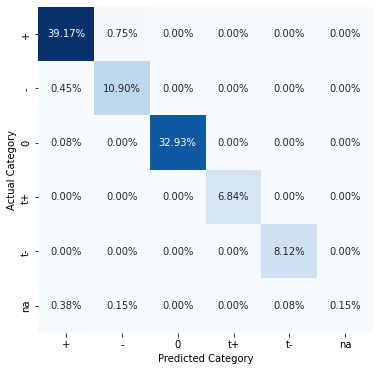

In [190]:
getResult(test_y, svm_predicted)

# Random Forest Classifier

In [191]:
rfc_predicted = getPredictions(train_features, test_features, train_y, "rfc")

Predicting using Random Forest...


Results...
╒═════╤══════════╤═════════════╤════════════╕
│     │   Recall │   Precision │   F1-score │
╞═════╪══════════╪═════════════╪════════════╡
│ +   │ 0.996234 │    0.937943 │   0.96621  │
├─────┼──────────┼─────────────┼────────────┤
│ -   │ 0.86755  │    0.984962 │   0.922535 │
├─────┼──────────┼─────────────┼────────────┤
│ 0   │ 0.993166 │    0.995434 │   0.994299 │
├─────┼──────────┼─────────────┼────────────┤
│ t+  │ 0.989011 │    0.989011 │   0.989011 │
├─────┼──────────┼─────────────┼────────────┤
│ t-  │ 0.944444 │    1        │   0.971429 │
├─────┼──────────┼─────────────┼────────────┤
│ na  │ 0.2      │    1        │   0.333333 │
╘═════╧══════════╧═════════════╧════════════╛
meanf1: 0.8628028160711098


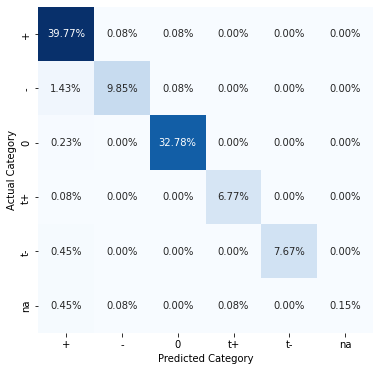

In [192]:
getResult(test_y, rfc_predicted)

# Logistic Regression

In [193]:
lg_predicted = getPredictions(train_features, test_features, train_y, "lg")

Predicting using Logistic Regression...


Results...
╒═════╤══════════╤═════════════╤════════════╕
│     │   Recall │   Precision │   F1-score │
╞═════╪══════════╪═════════════╪════════════╡
│ +   │ 0.984934 │    0.959633 │   0.972119 │
├─────┼──────────┼─────────────┼────────────┤
│ -   │ 0.89404  │    0.931034 │   0.912162 │
├─────┼──────────┼─────────────┼────────────┤
│ 0   │ 0.997722 │    1        │   0.99886  │
├─────┼──────────┼─────────────┼────────────┤
│ t+  │ 1        │    1        │   1        │
├─────┼──────────┼─────────────┼────────────┤
│ t-  │ 1        │    0.990826 │   0.995392 │
├─────┼──────────┼─────────────┼────────────┤
│ na  │ 0.2      │    1        │   0.333333 │
╘═════╧══════════╧═════════════╧════════════╛
meanf1: 0.8686443181362064


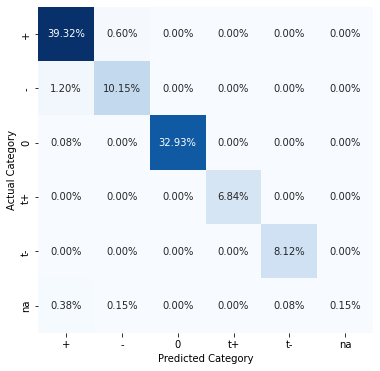

In [194]:
getResult(test_y, lg_predicted)

In [195]:
# test_features['label'] = test_y

# fOld 2

In [196]:
all_data = pd.read_csv('data/all-verb-cat-data.csv', delimiter='\t')
train_verbs_set = pd.read_csv('data/train-test-sets-hawp-3/train2.csv', delimiter='\t')
test_verbs_set = pd.read_csv('data/train-test-sets-hawp-3/test2.csv', delimiter='\t')

In [197]:
train_X, train_y = getDataAndLabels(train_verbs_set, all_data)
test_X, test_y = getDataAndLabels(test_verbs_set, all_data)

In [198]:
train_features, train_verbs = getFeatures(train_X)

                                               features
0     [N_NN, DM_DMD, N_NN, खरीद, RD_PUNC, NULL, NULL...
1     [QT_QTF, PR_PRQ, N_NN, खरीद, RD_PUNC, NULL, NU...
2     [N_NN, QT_QTC, N_NN, है, RD_PUNC, NULL, NULL, ...
3     [N_NST, QT_QTC, N_NN, है, CC_CCS, V_VM, RD_PUN...
4     [N_NN, V_VM, CC_CCS, बता, RD_PUNC, PR_PRP, N_N...
...                                                 ...
5190  [N_NN, QT_QTF, N_NN, है, RD_PUNC, NULL, NULL, ...
5191  [N_NN, PSP, N_NNP, निकाल, RD_PUNC, NULL, NULL,...
5192  [PSP, PR_PRP, N_NNP, है, RD_PUNC, NULL, NULL, ...
5193  [NULL, NULL, N_NN, निकाल, PSP, N_NST, N_NN, NU...
5194  [PSP, PR_PRQ, N_NN, था, RD_PUNC, NULL, NULL, c...

[5195 rows x 1 columns]


In [199]:
test_features, test_verbs = getFeatures(test_X)

                                               features
0     [NULL, N_NNP, N_NN, चला, V_VM, V_VAUX, V_VAUX,...
1     [N_NNP, N_NN, V_VM, सीख, V_VAUX, V_VAUX, RD_PU...
2     [QT_QTC, N_NN, N_NN, चला, PSP, N_NN, V_VM, num...
3     [V_VM, PSP, N_NN, कर, RD_PUNC, NULL, NULL, nmo...
4     [N_NN, PSP, N_NN, चला, RD_PUNC, NULL, NULL, nm...
...                                                 ...
1307  [QT_QTC, N_NN, JJ, रख, V_VAUX, RD_PUNC, NULL, ...
1308  [N_NST, PR_PRQ, N_NN, बच, V_VAUX, RD_PUNC, NUL...
1309  [N_NN, DM_DMD, PSP, ख़रीद, V_VAUX, RD_PUNC, CC...
1310  [V_VAUX, RD_PUNC, CC_CCS, बता, PR_PRP, N_NN, P...
1311  [PR_PRQ, N_NN, N_NN, कर, RD_PUNC, NULL, NULL, ...

[1312 rows x 1 columns]


In [200]:
print(len(train_features), len(train_y), len(test_features), len(test_y))

5195 5195 1312 1312


# SVM 

In [201]:
svm_predicted = getPredictions(train_features, test_features, train_y, "svm")

Predicting using SVM...


Results...
╒═════╤══════════╤═════════════╤════════════╕
│     │   Recall │   Precision │   F1-score │
╞═════╪══════════╪═════════════╪════════════╡
│ +   │ 0.964486 │    0.982857 │   0.973585 │
├─────┼──────────┼─────────────┼────────────┤
│ -   │ 0.97479  │    0.892308 │   0.931727 │
├─────┼──────────┼─────────────┼────────────┤
│ 0   │ 1        │    1        │   1        │
├─────┼──────────┼─────────────┼────────────┤
│ t+  │ 1        │    1        │   1        │
├─────┼──────────┼─────────────┼────────────┤
│ t-  │ 1        │    0.939655 │   0.968889 │
├─────┼──────────┼─────────────┼────────────┤
│ na  │ 0.636364 │    1        │   0.777778 │
╘═════╧══════════╧═════════════╧════════════╛
meanf1: 0.9419964133262609


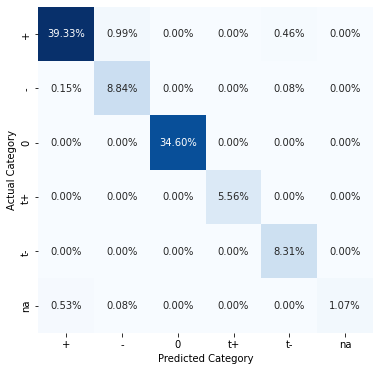

In [202]:
getResult(test_y, svm_predicted)

# Random Forest Classifier

In [203]:
rfc_predicted = getPredictions(train_features, test_features, train_y, "rfc")

Predicting using Random Forest...


Results...
╒═════╤══════════╤═════════════╤════════════╕
│     │   Recall │   Precision │   F1-score │
╞═════╪══════════╪═════════════╪════════════╡
│ +   │ 0.990654 │    0.94306  │   0.966272 │
├─────┼──────────┼─────────────┼────────────┤
│ -   │ 0.848739 │    0.95283  │   0.897778 │
├─────┼──────────┼─────────────┼────────────┤
│ 0   │ 0.995595 │    0.997792 │   0.996692 │
├─────┼──────────┼─────────────┼────────────┤
│ t+  │ 0.958904 │    0.985915 │   0.972222 │
├─────┼──────────┼─────────────┼────────────┤
│ t-  │ 0.944954 │    0.990385 │   0.967136 │
├─────┼──────────┼─────────────┼────────────┤
│ na  │ 0.727273 │    1        │   0.842105 │
╘═════╧══════════╧═════════════╧════════════╛
meanf1: 0.9403675759749689


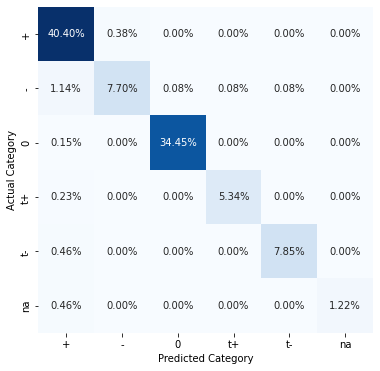

In [204]:
getResult(test_y, rfc_predicted)

# Logistic Regression

In [205]:
lg_predicted = getPredictions(train_features, test_features, train_y, "lg")

Predicting using Logistic Regression...


Results...
╒═════╤══════════╤═════════════╤════════════╕
│     │   Recall │   Precision │   F1-score │
╞═════╪══════════╪═════════════╪════════════╡
│ +   │ 0.962617 │    0.946691 │   0.954588 │
├─────┼──────────┼─────────────┼────────────┤
│ -   │ 0.865546 │    0.880342 │   0.872881 │
├─────┼──────────┼─────────────┼────────────┤
│ 0   │ 1        │    1        │   1        │
├─────┼──────────┼─────────────┼────────────┤
│ t+  │ 0.931507 │    1        │   0.964539 │
├─────┼──────────┼─────────────┼────────────┤
│ t-  │ 1        │    0.931624 │   0.964602 │
├─────┼──────────┼─────────────┼────────────┤
│ na  │ 0.545455 │    1        │   0.705882 │
╘═════╧══════════╧═════════════╧════════════╛
meanf1: 0.9104153444951147


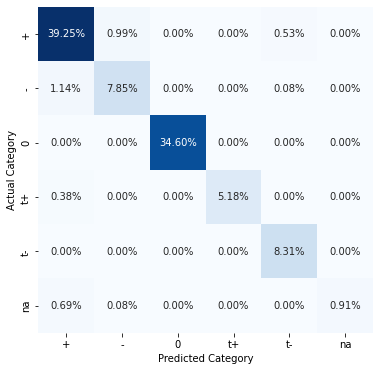

In [206]:
getResult(test_y, lg_predicted)

# fOld 1

In [207]:
all_data = pd.read_csv('data/all-verb-cat-data.csv', delimiter='\t')
train_verbs_set = pd.read_csv('data/train-test-sets-hawp-3/train1.csv', delimiter='\t')
test_verbs_set = pd.read_csv('data/train-test-sets-hawp-3/test1.csv', delimiter='\t')

In [208]:
train_X, train_y = getDataAndLabels(train_verbs_set, all_data)
test_X, test_y = getDataAndLabels(test_verbs_set, all_data)

In [209]:
train_features, train_verbs = getFeatures(train_X)

                                               features
0     [N_NN, DM_DMD, N_NN, खरीद, RD_PUNC, NULL, NULL...
1     [QT_QTF, PR_PRQ, N_NN, खरीद, RD_PUNC, NULL, NU...
2     [N_NN, QT_QTC, N_NN, है, RD_PUNC, NULL, NULL, ...
3     [N_NST, QT_QTC, N_NN, है, CC_CCS, V_VM, RD_PUN...
4     [N_NN, V_VM, CC_CCS, बता, RD_PUNC, PR_PRP, N_N...
...                                                 ...
5203  [N_NN, QT_QTF, N_NN, है, RD_PUNC, NULL, NULL, ...
5204  [N_NN, PSP, N_NNP, निकाल, RD_PUNC, NULL, NULL,...
5205  [PSP, PR_PRP, N_NNP, है, RD_PUNC, NULL, NULL, ...
5206  [NULL, NULL, N_NN, निकाल, PSP, N_NST, N_NN, NU...
5207  [PSP, PR_PRQ, N_NN, था, RD_PUNC, NULL, NULL, c...

[5208 rows x 1 columns]


In [210]:
test_features, test_verbs = getFeatures(test_X)

                                               features
0     [PSP, QT_QTC, N_NN, बैठ, V_VAUX, RD_PUNC, NULL...
1     [QT_QTC, N_NN, N_NNP, जा, RD_PUNC, NULL, NULL,...
2     [NULL, NULL, NULL, बता, RD_PUNC, PR_PRP, N_NN,...
3     [PSP, PR_PRQ, N_NN, रह, RD_PUNC, NULL, NULL, c...
4     [N_NST, QT_QTC, N_NN, था, CC_CCD, N_NNP, PSP, ...
...                                                 ...
1294  [N_NNP, N_NN, PSP, घूम, RD_PUNC, NULL, NULL, n...
1295  [PSP, QT_QTC, N_NN, चल, RD_PUNC, NULL, NULL, c...
1296  [PSP, QT_QTC, N_NN, चल, RD_PUNC, NULL, NULL, c...
1297  [NULL, N_NN, QT_QTF, मिला, PR_PRQ, N_NN, V_VM,...
1298  [V_VM, PR_PRQ, N_NN, चल, RD_PUNC, NULL, NULL, ...

[1299 rows x 1 columns]


In [211]:
print(len(train_features), len(train_y), len(test_features), len(test_y))

5208 5208 1299 1299


# SVM 

In [212]:
svm_predicted = getPredictions(train_features, test_features, train_y, "svm")

Predicting using SVM...


Results...
╒═════╤══════════╤═════════════╤════════════╕
│     │   Recall │   Precision │   F1-score │
╞═════╪══════════╪═════════════╪════════════╡
│ +   │ 0.980477 │    0.957627 │   0.968917 │
├─────┼──────────┼─────────────┼────────────┤
│ -   │ 0.88     │    0.88     │   0.88     │
├─────┼──────────┼─────────────┼────────────┤
│ 0   │ 0.998062 │    1        │   0.99903  │
├─────┼──────────┼─────────────┼────────────┤
│ t+  │ 0.988764 │    0.988764 │   0.988764 │
├─────┼──────────┼─────────────┼────────────┤
│ t-  │ 0.982143 │    0.973451 │   0.977778 │
├─────┼──────────┼─────────────┼────────────┤
│ na  │ 0.47619  │    1        │   0.645161 │
╘═════╧══════════╧═════════════╧════════════╛
meanf1: 0.9099417752441022


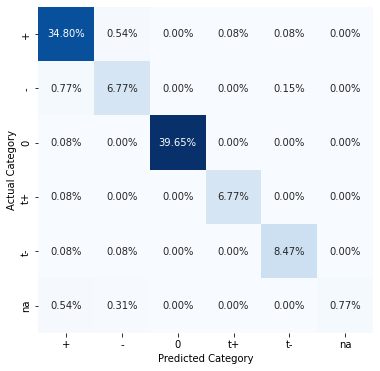

In [213]:
getResult(test_y, svm_predicted)

# Random Forest Classifier

In [214]:
rfc_predicted = getPredictions(train_features, test_features, train_y, "rfc")

Predicting using Random Forest...


Results...
╒═════╤══════════╤═════════════╤════════════╕
│     │   Recall │   Precision │   F1-score │
╞═════╪══════════╪═════════════╪════════════╡
│ +   │ 0.991323 │    0.896078 │   0.941298 │
├─────┼──────────┼─────────────┼────────────┤
│ -   │ 0.72     │    0.947368 │   0.818182 │
├─────┼──────────┼─────────────┼────────────┤
│ 0   │ 0.992248 │    1        │   0.996109 │
├─────┼──────────┼─────────────┼────────────┤
│ t+  │ 0.988764 │    0.977778 │   0.98324  │
├─────┼──────────┼─────────────┼────────────┤
│ t-  │ 0.928571 │    1        │   0.962963 │
├─────┼──────────┼─────────────┼────────────┤
│ na  │ 0.333333 │    1        │   0.5      │
╘═════╧══════════╧═════════════╧════════════╛
meanf1: 0.8669652642221234


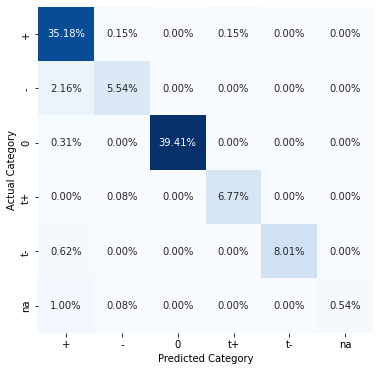

In [215]:
getResult(test_y, rfc_predicted)

# Logistic Regression

In [216]:
lg_predicted = getPredictions(train_features, test_features, train_y, "lg")

Predicting using Logistic Regression...


Results...
╒═════╤══════════╤═════════════╤════════════╕
│     │   Recall │   Precision │   F1-score │
╞═════╪══════════╪═════════════╪════════════╡
│ +   │ 0.976139 │    0.927835 │   0.951374 │
├─────┼──────────┼─────────────┼────────────┤
│ -   │ 0.8      │    0.851064 │   0.824742 │
├─────┼──────────┼─────────────┼────────────┤
│ 0   │ 0.992248 │    1        │   0.996109 │
├─────┼──────────┼─────────────┼────────────┤
│ t+  │ 0.966292 │    0.988506 │   0.977273 │
├─────┼──────────┼─────────────┼────────────┤
│ t-  │ 0.982143 │    0.964912 │   0.973451 │
├─────┼──────────┼─────────────┼────────────┤
│ na  │ 0.333333 │    1        │   0.5      │
╘═════╧══════════╧═════════════╧════════════╛
meanf1: 0.8704915798920161


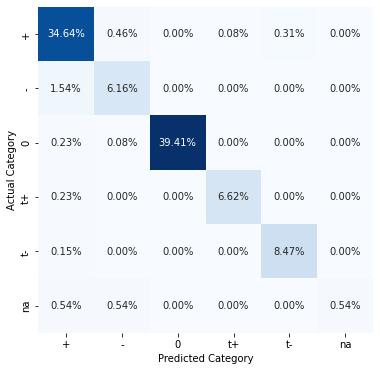

In [217]:
getResult(test_y, lg_predicted)

# fOld 4

In [218]:
all_data = pd.read_csv('data/all-verb-cat-data.csv', delimiter='\t')
train_verbs_set = pd.read_csv('data/train-test-sets-hawp-3/train4.csv', delimiter='\t')
test_verbs_set = pd.read_csv('data/train-test-sets-hawp-3/test4.csv', delimiter='\t')

In [219]:
train_X, train_y = getDataAndLabels(train_verbs_set, all_data)
test_X, test_y = getDataAndLabels(test_verbs_set, all_data)

In [220]:
train_features, train_verbs = getFeatures(train_X)

                                               features
0     [N_NN, DM_DMD, N_NN, खरीद, RD_PUNC, NULL, NULL...
1     [QT_QTF, PR_PRQ, N_NN, खरीद, RD_PUNC, NULL, NU...
2     [N_NN, QT_QTC, N_NN, है, RD_PUNC, NULL, NULL, ...
3     [N_NST, QT_QTC, N_NN, है, CC_CCS, V_VM, RD_PUN...
4     [N_NN, V_VM, CC_CCS, बता, RD_PUNC, PR_PRP, N_N...
...                                                 ...
5238  [NULL, NULL, PR_PRP, निपट, PSP, PSP, N_NN, NUL...
5239  [N_NN, PSP, N_NN, छोड़, RD_PUNC, NULL, NULL, n...
5240  [N_NN, PSP, N_NN, था, CC_CCD, QT_QTC, N_NN, nm...
5241  [PSP, N_NN, RP_NEG, था, RD_PUNC, NULL, NULL, c...
5242  [PSP, RP_INTF, QT_QTF, है, RD_PUNC, NULL, NULL...

[5243 rows x 1 columns]


In [221]:
test_features, test_verbs = getFeatures(test_X)

                                               features
0     [PSP, QT_QTF, N_NN, खरीद, RD_PUNC, NULL, NULL,...
1     [PSP, QT_QTC, N_NN, खरीद, CC_CCD, N_NN, PSP, c...
2     [PSP, QT_QTC, N_NN, कर, RD_PUNC, NULL, NULL, c...
3     [NULL, NULL, QT_QTF, मिला, RD_PUNC, N_NNP, PSP...
4     [PSP, PR_PRQ, N_NN, कर, RD_PUNC, NULL, NULL, c...
...                                                 ...
1259  [N_NN, QT_QTF, N_NN, है, RD_PUNC, NULL, NULL, ...
1260  [N_NN, PSP, N_NNP, निकाल, RD_PUNC, NULL, NULL,...
1261  [PSP, PR_PRP, N_NNP, है, RD_PUNC, NULL, NULL, ...
1262  [NULL, NULL, N_NN, निकाल, PSP, N_NST, N_NN, NU...
1263  [PSP, PR_PRQ, N_NN, था, RD_PUNC, NULL, NULL, c...

[1264 rows x 1 columns]


In [222]:
print(len(train_features), len(train_y), len(test_features), len(test_y))

5243 5243 1264 1264


# SVM 

In [223]:
svm_predicted = getPredictions(train_features, test_features, train_y, "svm")

Predicting using SVM...


Results...
╒═════╤══════════╤═════════════╤════════════╕
│     │   Recall │   Precision │   F1-score │
╞═════╪══════════╪═════════════╪════════════╡
│ +   │ 0.964015 │    0.964015 │   0.964015 │
├─────┼──────────┼─────────────┼────────────┤
│ -   │ 0.92126  │    0.835714 │   0.876404 │
├─────┼──────────┼─────────────┼────────────┤
│ 0   │ 0.997701 │    1        │   0.998849 │
├─────┼──────────┼─────────────┼────────────┤
│ t+  │ 1        │    0.970149 │   0.984848 │
├─────┼──────────┼─────────────┼────────────┤
│ t-  │ 0.977273 │    1        │   0.988506 │
├─────┼──────────┼─────────────┼────────────┤
│ na  │ 0.428571 │    1        │   0.6      │
╘═════╧══════════╧═════════════╧════════════╛
meanf1: 0.902103854980984


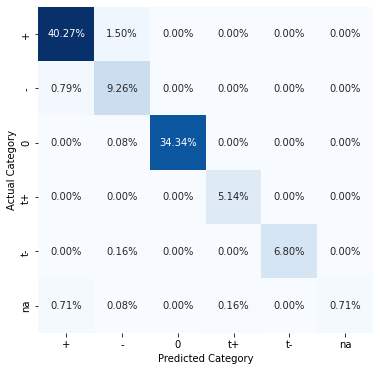

In [224]:
getResult(test_y, svm_predicted)

# Random Forest Classifier

In [225]:
rfc_predicted = getPredictions(train_features, test_features, train_y, "rfc")

Predicting using Random Forest...


Results...
╒═════╤══════════╤═════════════╤════════════╕
│     │   Recall │   Precision │   F1-score │
╞═════╪══════════╪═════════════╪════════════╡
│ +   │ 0.984848 │    0.942029 │   0.962963 │
├─────┼──────────┼─────────────┼────────────┤
│ -   │ 0.866142 │    0.92437  │   0.894309 │
├─────┼──────────┼─────────────┼────────────┤
│ 0   │ 0.997701 │    0.997701 │   0.997701 │
├─────┼──────────┼─────────────┼────────────┤
│ t+  │ 1        │    0.970149 │   0.984848 │
├─────┼──────────┼─────────────┼────────────┤
│ t-  │ 0.920455 │    0.987805 │   0.952941 │
├─────┼──────────┼─────────────┼────────────┤
│ na  │ 0.428571 │    1        │   0.6      │
╘═════╧══════════╧═════════════╧════════════╛
meanf1: 0.8987937861327923


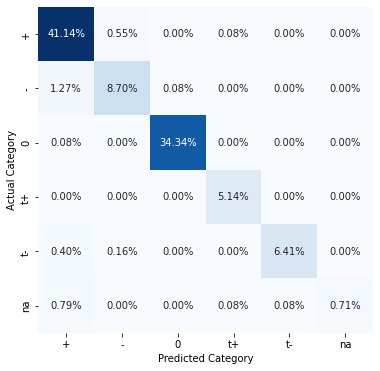

In [226]:
getResult(test_y, rfc_predicted)

# Logistic Regression

In [227]:
lg_predicted = getPredictions(train_features, test_features, train_y, "lg")

Predicting using Logistic Regression...


Results...
╒═════╤══════════╤═════════════╤════════════╕
│     │   Recall │   Precision │   F1-score │
╞═════╪══════════╪═════════════╪════════════╡
│ +   │ 0.954545 │    0.956357 │   0.95545  │
├─────┼──────────┼─────────────┼────────────┤
│ -   │ 0.897638 │    0.814286 │   0.853933 │
├─────┼──────────┼─────────────┼────────────┤
│ 0   │ 0.997701 │    1        │   0.998849 │
├─────┼──────────┼─────────────┼────────────┤
│ t+  │ 0.984615 │    0.969697 │   0.977099 │
├─────┼──────────┼─────────────┼────────────┤
│ t-  │ 0.977273 │    0.966292 │   0.971751 │
├─────┼──────────┼─────────────┼────────────┤
│ na  │ 0.285714 │    0.75     │   0.413793 │
╘═════╧══════════╧═════════════╧════════════╛
meanf1: 0.8618126376281955


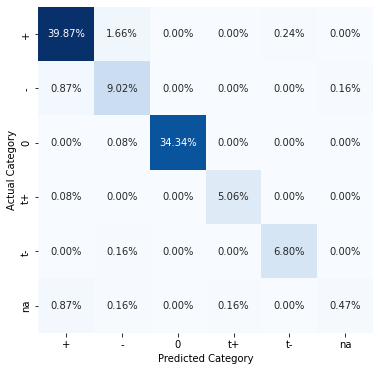

In [228]:
getResult(test_y, lg_predicted)